In [1]:
%matplotlib inline

In [2]:
# Add imports
import math
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import Animation, FuncAnimation, PillowWriter 
from IPython.display import Image
from sympy import *
init_printing()

import graphviz
import subprocess # to run asymptote
import shlex

from tempfile import NamedTemporaryFile
import base64
import uuid
import os

# Methods of solutions of inverse and forward kinematics in a planar robot arm

## Table of content
1. [Introduction](#chapter1)
2. [Kinematics](#chapter2)<br>
   2.1. [Robot Kinematics](#chapter21)
3. [Forward kinematics](#chapter3)<br>
   3.1. [Global functions](#chapter31)<br>
   3.2. [Global Definitions](#chapter32)<br>
   3.3. [Methods to solve the forward kinematics problem](#chapter33)<br>
       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.3.1. [Geometric Approach](#chapter331)<br>
       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.3.1.1 [Implementation and simulation of the Geometric Approach](#chapter3311)<br>
       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.3.2. [Denavit-Hartenberg Parameters](#chapter332)<br>
       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.3.2.1 [Implementation and simulation of the Denavit-Hartenberg Parameters Approach](#chapter3321)<br>
       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.3.3. [Homogeneous Transformation Matrices](#chapter333)<br>
       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.3.3.1 [Implementation and simulation of the Homogeneous Transformation Matrices approach](#chapter3331)<br>
4. [Inverse kinematics](#chapter4)<br>
    4.1. [Methods to solve Inverse kinematics problem](#chapter41)<br>
       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.1.1. [Geometric Approach](#chapter411)<br>
       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.1.1.1 [Implementation and simulation of the Geometric Approach](#chapter4111)<br>
       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.1.2. [Algebraic Approach](#chapter412)<br>
       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.1.2.1 [Implementation and simulation of the Algebraic Approach](#chapter4121)<br>
       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.1.3. [Newton's Method](#chapter413)<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.1.3.1 [Implementation and simulation of Newton's Approach](#chapter4131)<br>

5. [Literature](#chapter5)<br>
        


   


   

       


    



       


       


        


       



       

       
   

    

## Abstract

This notebook presents an overview of the methods of solutions of inverse and forward kinematics problem in a planar robot arm. The notebook is focused on the demonstration of simple control of a two-link robotic arm (2 degrees of freedom - DOF) implemented in Python using simulation of the implemented methods.  

## Goals and Motivation

The main motivation to create this notebook is to provide an overview of the kinematics of a robot arm (2 DOF) that can be used by the lecture "Kinematics" in the faculty of Mathematics and Informatics by the institute __Mechatronics and Robotics__ at the Sofia University "St. Kliment Ohridski".

Here the goals of this project:
- Mathematical description and explanation of the formard and inverse kinemetics of a robot arm with 2 degree of freedom (DOF) 
- Simulation of the implemented methods using the standard library matplotlib and specific robotic libraries

## 1. Introduction <a class="anchor" id="chapter1"></a>

Have you ever wondered how a robot arm figures out how to move its gripper to that exact spot you programmed? It all boils down to kinematics, which is basically the math behind robot motion. In this notebook, we will delve into two crucial parts of kinematics: forward kinematics and inverse kinematics. These might sound fancy, but they're like two sides of the same coin, both are the fundamental movement principle for getting a robot arm to do its job.

Forward kinematics is like looking at a map – you know the robot's joint angles (like how far its elbow is bent), and you can figure out where the gripper will end up. Inverse kinematics is like trying to get somewhere on that map – you tell the robot where you want the gripper to be, and it has to figure out the right joint angles to get there. Understanding both these sides is essential for making robot arms move with precision and control, whether you're assembling cars, painting a masterpiece, or even performing surgery!

## 2. Kinematics <a class="anchor" id="chapter2"></a>

Kinematics is a subfield/branch of physics and mathematics within classical mechanics. It focuses on describing the geometrically possible motion of points, objects, and systems of bodies without considering the object mass and forces which have inducted motion. In other words, kinematics deals with the study of motion itself, independent of the forces that drive it. The term "kinematics" originates from the Greek word "kinesis" which means motion.



### 2.1 Robot Kinematics <a class="anchor" id="chapter21"></a>

Robot kinematics studies the relationship between the dimensions and connectivity of kinematic chains and the position, velocity and acceleration of each of the links in the robotic system, in order to plan and control movement and to compute actuator forces and torques. The relationship between mass and inertia properties, motion, and the associated forces and torques is studied as part of robot dynamics.

There are two methods of robot Kinematics:
- __Forward kinematics__
- __Inverse Kinematics__

In the figure below is showed the difference between the forward and inverse kinematics.

![Difference between forward and inverse kinematics](figures/Difference_between_FK_abd_IK.png)
![Difference between forward and inverse kinematics](figures/Difference_between_FK_abd_IK_01.png)

## 3 Forward kinematics <a class="anchor" id="chapter3"></a>

A manipulator consists of serial links that are interconnected through revolute or thrust joints from the base frame to the end effector. The calculation of the position and orientation of the end-effector from the joint variables is called forward kinematics. In order to systematically obtain the forward kinematics of a robotic mechanism, an appropriate kinematic model should be used.

### 3.1 Global functions <a class="anchor" id="chapter31"></a>
The function __anim_to_html()__ is used to display the simulation of the different implementations of forward and inverse kinematics. 

In [3]:
GIF_TAG = """<img src="data:image/gif;bogus=ABCDEF;base64,{0}">"""
def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        # create a temp file in the folder "tmp" in the current directory
        tempfilename = f'image-{uuid.uuid4()}.gif'
        tmp_file_path = os.path.join(os.path.abspath(''),'tmp',tempfilename)    
        anim.save(tmp_file_path, writer='imagemagick', fps=4)
        video = open(tmp_file_path, "rb").read()
        anim._encoded_video = base64.b64encode(video).decode('utf-8')
    return GIF_TAG.format(anim._encoded_video)
Animation._repr_html_ = anim_to_html


# Initialize function for the animation
def init():
    line.set_data([], [])
    joint1.set_data([], [])
    joint2.set_data([], [])
    infoline.set_text('')
    return line, infoline

### 3.2 Global Definitions <a class="anchor" id="chapter32"></a>

In [4]:
t1 = Symbol('theta_1')
t2 = Symbol('theta_2')

L1 = Symbol('L_1')
L2 = Symbol('L_2')

L1 = 0.45 # Link 1 length in meters
L2 = 0.48 # Link 2 length in meters
t1 = 0.0  # Initial angle for link 1
t2 = 0.0  # Initial angle for link 2

# Define the robot's link lengths
l1 = 0.45 # Link 1 length in meters
l2 = 0.48 # Link 2 length in meters

 ### 3.3 Methods to solve the forward kinematics problem <a class="anchor" id="chapter33"></a>
- __Geometric Approach__
- __Denavit-Hartenberg (DH) Parameters__
- __Homogeneous Transformation Matrices__
- Product of Exponentials (POE) Method
- Quaternion-Based Methods
- Dual Quaternions

The geometric approach and the Denavit-Hartenberg (DH) Parameters are the most popular solutions of this problem. In this notebook will be detailed described the first three methods listed above.

#### 3.3.1 Geometric Approach <a class="anchor" id="chapter331"></a>
The geometric approach uses geometric properties and relationships to solve for joint angles. It often involves decomposing the problem into simpler geometric shapes.

It was looking for how much is $x_1$ and $x_2$ as $x$ and $y$ at point $P$. Using the geometric approach shown in the figure below the following solution is arrived at.

![Geometric_Approach_Forward_Kinematics](figures/geometric_aproach_forward_kinematcis.png)

*A geometric approach to the solution of the straight kinematics problem of a robot with two degrees of freedom*

$$x_{1} = l_{1}\cos \theta_{1}$$

$$y_{1} = l_{1}\sin \theta_{1}$$

$$x = l_{1}\cos \theta_{1} + l_{2}cos(\theta_{1} + \theta_{2})$$

$$y = l_{1}\sin \theta_{1} + l_{2}sin(\theta_{1} + \theta_{2})$$

#### 3.3.1.1 Implementation and simulation of the Geometric Approach <a class="anchor" id="chapter3311"></a>

MovieWriter imagemagick unavailable; using Pillow instead.


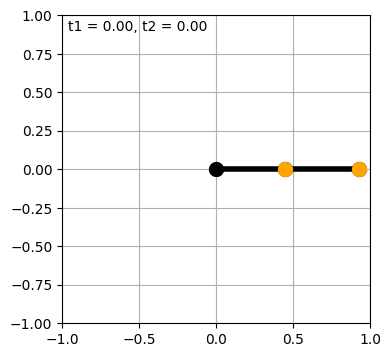

In [5]:
# Define the link lengths and initial angles

# Create a figure and axis for the plot
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False, xlim=(-1, 1), ylim=(-1, 1))

ax.plot(105 / math.pi, 105 / math.pi, '-ro', label='line & marker - no line because only 1 point')
ax.grid()


# Initialize the plot elements
line, = ax.plot([], [], 'o-', lw=4, mew=5, color='black')
joint1, = ax.plot([], [], 'o-', markersize=10, color='orange')  # Joint 1 with red color
joint2, = ax.plot([], [], 'o-', markersize=10, color='orange')  # Joint 2 with green color
infoline = ax.text(0.02, 0.95, '', transform=ax.transAxes)

# Animate function to update the plot
def animate(i):
    global t1, t2
    if i < 10:
        t1 += math.pi / 30.0
    elif i < 20:
        t2 += math.pi / 30.0
    else:
        t1 -= math.pi / 30.0
        t2 -= math.pi / 30.0
    
    # Compute the positions of the arm links
    x1 = L1 * np.cos(t1)
    y1 = L1 * np.sin(t1)
    x2 = x1 + L2 * np.cos(t1 + t2)
    y2 = y1 + L2 * np.sin(t1 + t2)
    
    # Update the data for the line and info text
    line.set_data([0, x1, x2], [0, y1, y2])
    joint1.set_data([x1], [y1])
    joint2.set_data([x2], [y2])
    infoline.set_text(f't1 = {t1:.2f}, t2 = {t2:.2f}')
    return line, infoline

# Create the animation
FuncAnimation(fig, animate, frames=30, interval=25, blit=True, init_func=init)

# Show the plot
#plt.show()

#### 3.3.2 Denavit-Hartenberg Parameters <a class="anchor" id="chapter332"></a>

Denavit and Hartenberg (1955) showed that a general transformation between two joints requires four parameters. These parameters known as the
Denavit-Hartenberg (DH) parameters have become the standard for describing robot kinematics.

### DH Parameters
For each link $i$, the DH parameters are:
- $a_i$: Link length
- $\alpha_i$: Link twist
- $d_i$: Link offset
- $\theta_i$: Joint angle

### Transformation Matrix
The transformation matrix for each joint $i$ is given by:
$$
T_i = \begin{bmatrix}
\cos(\theta_i) & -\sin(\theta_i)\cos(\alpha_i) & \sin(\theta_i)\sin(\alpha_i) & a_i\cos(\theta_i) \\
\sin(\theta_i) & \cos(\theta_i)\cos(\alpha_i) & -\cos(\theta_i)\sin(\alpha_i) & a_i\sin(\theta_i) \\
0 & \sin(\alpha_i) & \cos(\alpha_i) & d_i \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

For a two-link planar robot, we have:
- $a_1$, $\alpha_1$, $d_1$, $\theta_1$ for Link 1
- $a_2$, $\alpha_2$, $d_2$, $\theta_2$ for Link 2

#### Link 1 Transformation Matrix
$$
T_1 = \begin{bmatrix}
\cos(\theta_1) & -\sin(\theta_1) & 0 & a_1\cos(\theta_1) \\
\sin(\theta_1) & \cos(\theta_1) & 0 & a_1\sin(\theta_1) \\
0 & 0 & 1 & d_1 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

#### Link 2 Transformation Matrix
$$
T_2 = \begin{bmatrix}
\cos(\theta_2) & -\sin(\theta_2) & 0 & a_2\cos(\theta_2) \\
\sin(\theta_2) & \cos(\theta_2) & 0 & a_2\sin(\theta_2) \\
0 & 0 & 1 & d_2 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

#### Overall Transformation Matrix
The overall transformation matrix $T$ from the base frame to the end-effector is given by:
$$
T = T_1 \cdot T_2
$$

#### Calculating $T$
Substitute the values of $T_1$ and $T_2$ into the multiplication:
$$
T = \begin{bmatrix}
\cos(\theta_1) & -\sin(\theta_1) & 0 & a_1\cos(\theta_1) \\
\sin(\theta_1) & \cos(\theta_1) & 0 & a_1\sin(\theta_1) \\
0 & 0 & 1 & d_1 \\
0 & 0 & 0 & 1
\end{bmatrix}
\cdot
$$

$$
\begin{bmatrix}
\cos(\theta_2) & -\sin(\theta_2) & 0 & a_2\cos(\theta_2) \\
\sin(\theta_2) & \cos(\theta_2) & 0 & a_2\sin(\theta_2) \\
0 & 0 & 1 & d_2 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

Multiplying these matrices results in the overall transformation matrix:
$$
T = \begin{bmatrix}
\cos(\theta_1)\cos(\theta_2) - \sin(\theta_1)\sin(\theta_2) & -\cos(\theta_1)\sin(\theta_2) - \sin(\theta_1)\cos(\theta_2) & 0 & a_1\cos(\theta_1) + a_2(\cos(\theta_1)\cos(\theta_2) - \sin(\theta_1)\sin(\theta_2)) \\
\sin(\theta_1)\cos(\theta_2) + \cos(\theta_1)\sin(\theta_2) & -\sin(\theta_1)\sin(\theta_2) + \cos(\theta_1)\cos(\theta_2) & 0 & a_1\sin(\theta_1) + a_2(\sin(\theta_1)\cos(\theta_2) + \cos(\theta_1)\sin(\theta_2)) \\
0 & 0 & 1 & d_1 + d_2 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

This matrix $T$ gives the position and orientation of the end-effector relative to the base frame.


#### 3.3.2.1 Implementation and simulation of the Denavit-Hartenberg Parameters Approach <a class="anchor" id="chapter3321"></a>

MovieWriter imagemagick unavailable; using Pillow instead.


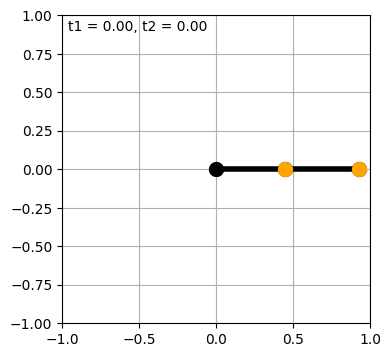

In [6]:
# Function to compute the transformation matrix using D-H parameters
def dh_transform(theta, d, a, alpha):
    return np.array([
        [np.cos(theta), -np.sin(theta) * np.cos(alpha),  np.sin(theta) * np.sin(alpha), a * np.cos(theta)],
        [np.sin(theta),  np.cos(theta) * np.cos(alpha), -np.cos(theta) * np.sin(alpha), a * np.sin(theta)],
        [0,              np.sin(alpha),                 np.cos(alpha),                 d],
        [0,              0,                             0,                             1]
    ])

# Compute the transformation matrices
def compute_transformations(t1, t2):
    T1 = dh_transform(t1, 0, L1, 0)
    T2 = T1 @ dh_transform(t2, 0, L2, 0)
    return T1, T2

# Extract the coordinates from the transformation matrices
def extract_coords(T1, T2):
    x0, y0 = 0, 0  # Base coordinates
    x1, y1 = T1[0, 3], T1[1, 3]
    x2, y2 = T2[0, 3], T2[1, 3]
    return [x0, x1, x2], [y0, y1, y2]

# Create the figure and axis
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False, xlim=(-1, 1), ylim=(-1, 1))
ax.grid()
line, = ax.plot([], [], 'o-', lw=4, mew=5, color='black')
joint1, = ax.plot([], [], 'o-', markersize=10, color='orange')  # Joint 1 with red color
joint2, = ax.plot([], [], 'o-', markersize=10, color='orange')  # Joint 2 with green color
infoline = ax.text(0.02, 0.95, '', transform=ax.transAxes)

# Animate function to update the plot
def animate(i):
    global t1, t2
    if i < 10:
        t1 += math.pi / 30.0
    elif i < 20:
        t2 += math.pi / 30.0
    else:
        t1 -= math.pi / 30.0
        t2 -= math.pi / 30.0
    
    T1, T2 = compute_transformations(t1, t2)
    x, y = extract_coords(T1, T2)
    
    line.set_data(x, y)
    joint1.set_data([x[1]], [y[1]])
    joint2.set_data([x[2]], [y[2]])
    infoline.set_text(f't1 = {t1:.2f}, t2 = {t2:.2f}')
    return line, infoline

# Create the animation
FuncAnimation(fig, animate, frames=30, interval=25, blit=True, init_func=init)


#### 3.3.3 Homogeneous Transformation Matrices <a class="anchor" id="chapter333"></a>

The homogeneous transformation matrices enable us to combine rotation matrices (which have 3 rows and 3 columns) and displacement vectors (which have 3 rows and 1 column) into a single matrix. They are an important concept of forward kinematics. 
We will use homogeneous transformation matrices to compute the forward kinematics for a two-link planar robot.

#### A homogeneous transformation matrix for a 2D robot (planar robot) is given by:
$$
T = \begin{bmatrix}
R & d \\
0 & 1
\end{bmatrix}
$$
where:
- $R$ is the 2x2 rotation matrix.
- $d$ is the 2x1 translation vector.
- The bottom row is $[0 \ 0 \ 1]$.

#### Rotation Matrix
The rotation matrix for a joint with angle $\theta$ is:
$$
R(\theta) = \begin{bmatrix}
\cos(\theta) & -\sin(\theta) \\
\sin(\theta) & \cos(\theta)
\end{bmatrix}
$$

#### Transformation Matrix for Each Link
For a two-link planar robot, we have two joints with angles $\theta_1$ and $\theta_2$, and link lengths $l_1$ and $l_2$.

#### Link 1 Transformation Matrix
The transformation matrix for link $1$ is:
$$
T_1 = \begin{bmatrix}
\cos(\theta_1) & -\sin(\theta_1) & l_1\cos(\theta_1) \\
\sin(\theta_1) & \cos(\theta_1) & l_1\sin(\theta_1) \\
0 & 0 & 1
\end{bmatrix}
$$

#### Link 2 Transformation Matrix
The transformation matrix for link $2$ is:
$$
T_2 = \begin{bmatrix}
\cos(\theta_2) & -\sin(\theta_2) & l_2\cos(\theta_2) \\
\sin(\theta_2) & \cos(\theta_2) & l_2\sin(\theta_2) \\
0 & 0 & 1
\end{bmatrix}
$$

### Overall Transformation Matrix
The overall transformation matrix $(T)$ from the base frame to the end-effector is given by:
$$
T = T_1 \cdot T_2
$$

#### Calculating $T$
Substitute the values of $T_1$ and $T_2$ into the multiplication:
$$
T = \begin{bmatrix}
\cos(\theta_1) & -\sin(\theta_1) & l_1\cos(\theta_1) \\
\sin(\theta_1) & \cos(\theta_1) & l_1\sin(\theta_1) \\
0 & 0 & 1
\end{bmatrix}
\cdot
$$

$$
\begin{bmatrix}
\cos(\theta_2) & -\sin(\theta_2) & l_2\cos(\theta_2) \\
\sin(\theta_2) & \cos(\theta_2) & l_2\sin(\theta_2) \\
0 & 0 & 1
\end{bmatrix}
$$

Multiplying these matrices results in the overall transformation matrix:
$$
T = \begin{bmatrix}
\cos(\theta_1)\cos(\theta_2) - \sin(\theta_1)\sin(\theta_2) & -\cos(\theta_1)\sin(\theta_2) - \sin(\theta_1)\cos(\theta_2) & l_1\cos(\theta_1) + a_2(\cos(\theta_1)\cos(\theta_2) - \sin(\theta_1)\sin(\theta_2)) \\
\sin(\theta_1)\cos(\theta_2) + \cos(\theta_1)\sin(\theta_2) & -\sin(\theta_1)\sin(\theta_2) + \cos(\theta_1)\cos(\theta_2) & l_1\sin(\theta_1) + a_2(\sin(\theta_1)\cos(\theta_2) + \cos(\theta_1)\sin
\end{bmatrix}
$$

#### 3.3.3.1 Implementation and simulation of the Homogeneous Transformation Matrices approach <a class="anchor" id="chapter3331"></a>

Below is implemented and simulated the Homogeneous Transformation Matrices approach.

MovieWriter imagemagick unavailable; using Pillow instead.


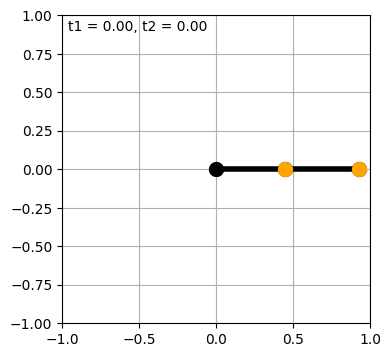

In [7]:
# Function to compute the homogeneous transformation matrix
def homogeneous_transform(theta, a):
    return np.array([
        [np.cos(theta), -np.sin(theta), a * np.cos(theta)],
        [np.sin(theta),  np.cos(theta), a * np.sin(theta)],
        [0,              0,             1]
    ])

# Compute the transformation matrices
def compute_transformations(t1, t2):
    T1 = homogeneous_transform(t1, L1)
    T2 = T1 @ homogeneous_transform(t2, L2)
    return T1, T2

# Extract the coordinates from the transformation matrices
def extract_coords(T1, T2):
    x0, y0 = 0, 0  # Base coordinates
    x1, y1 = T1[0, 2], T1[1, 2]
    x2, y2 = T2[0, 2], T2[1, 2]
    return [x0, x1, x2], [y0, y1, y2]

# Create the figure and axis
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False, xlim=(-1, 1), ylim=(-1, 1))
ax.grid()
line, = ax.plot([], [], 'o-', lw=4, mew=5, color='black')
joint1, = ax.plot([], [], 'o-', markersize=10, color='orange')  # Joint 1 with red color
joint2, = ax.plot([], [], 'o-', markersize=10, color='orange')  # Joint 2 with green color
infoline = ax.text(0.02, 0.95, '', transform=ax.transAxes)

# Animate function to update the plot
def animate(i):
    global t1, t2
    if i < 10:
        t1 += math.pi / 30.0
    elif i < 20:
        t2 += math.pi / 30.0
    else:
        t1 -= math.pi / 30.0
        t2 -= math.pi / 30.0
    
    T1, T2 = compute_transformations(t1, t2)
    x, y = extract_coords(T1, T2)
    
    line.set_data(x, y)
    joint1.set_data([x[1]], [y[1]])
    joint2.set_data([x[2]], [y[2]])
    infoline.set_text(f't1 = {t1:.2f}, t2 = {t2:.2f}')
    return line, infoline

# Create the animation
FuncAnimation(fig, animate, frames=30, interval=25, blit=True, init_func=init)


## 4 Inverse kinematics <a class="anchor" id="chapter4"></a>

Solving the inverse kinematics problem is computationally expansive and typically time consuming in real-time manipulator control. The tasks to be performed by the manipulator are in __Cartesian space__, while the actuators operate in general space. The Cartesian space includes an orientation matrix and a position vector. However, the joint space is represented by joint angles. The transformation of position and orientation of a manipulator with a finite effector from Cartesian space to joint space is called inverse kinematic problem. 
The inverse kinematics problem seeks a solution to the question, __"Which angles/translations should be set in the joints so that the end effector is in the desired position and desired orientation?"__. The main problem here, is that __not always only one solution can be found__. Although there is only one end effector position for a configuration of joint variables, there can be multiple configurations for a desired end effector position.


### 4.1 Methods to solve Inverse kinematics problem <a class="anchor" id="chapter41"></a>

- __Analytical Methods__
   - __Algebraic Approach__
   - __Geometric Approach__
- __Numerical Methods__
   - __Newton's Method__
   - Iterative Approaches
   - Jacobian Inverse Method
   - Jacobian Transpose Method
   - Levenberg-Marquardt Algorithm
- __Heuristic and AI-Based Methods__
   - Genetic Algorithms
   - Neural Networks
   - Particle Swarm Optimization (PSO)
 
In this notebook we will look at in detail the most popular analytical and numerical methods.  

#### 4.1.1 Geometric Approach <a class="anchor" id="chapter411"></a>

The geometric solution approach is based on decomposing the spatial geometry of the manipulator into several plane geometry problems. It is applied to simple robot structures, such as a robotic arm with two degrees of freedom whose joints are both revolute and the link lengths are $l_1$ and $l_2$, as shown in figure below.

![Geometric solution approach to the inverse problem ma kinematics of a robot with two degrees of freedom ](figures/geometrical_approach_inverse_cinematic.png)

*Figure: Geometric approach to the inverse problem of kinematics of a robot with two degrees of freedom*

To simplify the notation, the following abbreviated notation of $sin$ and $cos$ is used:
$$C_{1} = \cos{\theta_{1},\ \ \ S_{1} = sin\theta_{1}}$$

$$C_{12} = {cos(\theta_{1} + \theta_{2})}{,\ \ \ S_{12} = sin(\theta_{1} + \theta_{2})}$$

The components of the point $P$ ( $P_{x}$ and $P_{y}$ ) are defined as follows.

$$P_{x} = l_{1}C_{1} + l_{2}C_{12}$$

$$P_{y} = l_{1}S_{1} + l_{2}S_{12}$$

After revealing the
$C_{12} = \cos\left( \theta_{1} + \theta_{2} \right) \rightarrow C_{12} = C_{1}C_{2} - S_{1}S_{2}\ and\ of\ S_{12} = \sin\left( \theta_{1} + \theta_{2} \right) \rightarrow S_{12} = S_{1}C_{2} + C_{1}S_{2}.\ $ The solution of $\theta_{2}$ can be calculated from summation of the quadrature of $P_{x}$ and $P_{y}$.

$$P_{x}^{2} = l_{1}^{2}C_{1}^{2} + l_{2}^{2}C_{12}^{2} + 2l_{1}l_{2}C_{1}C_{12}$$

$$P_{y}^{2} = l_{1}^{2}S_{1}^{2} + l_{2}^{2}S_{12}^{2} + 2l_{1}l_{2}S_{1}S_{12}$$

$$P_{x}^{2} + \ P_{y}^{2} = l_{1}^{2}\left( C_{1}^{2} + S_{1}^{2} \right) + l_{2}^{2}\left( C_{12}^{2} + S_{12}^{2} \right) + 2l_{1}l_{2}(C_{1}C_{12} + S_{1}S_{12})$$

Since $S_{1}^{2} + C_{1}^{2} = 1$, $C_{12} = C_{1}C_{2} - S_{1}S_{2}$ , and $S_{12} = S_{1}C_{2} + C_{1}S_{2}$ the following simplification of the expression above follows:

$$P_{x}^{2} + \ P_{y}^{2} = l_{1}^{2} + l_{2}^{2} + 2l_{1}l_{2}(C_{1}(C_{1}C_{2} - S_{1}S_{2}) + S_{1}(S_{1}C_{2} + C_{1}S_{2}))$$

$$= l_{1}^{2} + l_{2}^{2} + 2l_{1}l_{2}(C_{1}^{2}C_{2} - C_{1}S_{1}S_{2} + S_{1}^{2}C_{2} + C_{1}S_{1}S_{2})$$

$$= l_{1}^{2} + l_{2}^{2} + 2l_{1}l_{2}(C_{2}(C_{1}^{2} + S_{1}^{2}))$$

$$P_{x}^{2} + \ P_{y}^{2} = l_{1}^{2} + l_{2}^{2} + 2l_{1}l_{2}C_{2}$$


And so $C_{2}$ and accordingly $\cos \theta_{2}$ is equal to:

$$\cos \theta_{2} = \frac{P_{x}^{2} + P_{y}^{2} - l_{1}^{2} - l_{2}^{2}}{2l_ {1}l_{2}}$$

As $S_{i}^{2} + C_{i}^{2} = 1\ (i = 1,2,3,\ \ldots N),\ S_{2}$ respectively $sin\theta_{2}$ is equal to
$$\sin Q_{2} = \pm \sqrt{1 - \left( \frac{P_{x}^{2} + P_{y}^{2} - l_{1}^{2} - l_{2}^{2}}{2l_{1}l_{2}} \right)^{2}}$$

Finally, it turns out that $\theta_{2}$ has two possible solutions and can be recorded as follows:

$$\theta_{2} = atan2\ \left( \pm \sqrt{1 - \left( \frac{P_{x}^{2} + P_{y}^{2} - l_{1}^{2} - l_{2}^{2}}{2l_{1}l_{2}} \right)^{2}},\ \frac{P_{x}^{2} + P_{y}^{2} - l_{1}^{2} - l_{2}^{2}}{2l_{1}l_{2}} \right)$$

To find the solution of $\theta_{1}$ with respect to the parameters of the relationship and the known angle $\theta_{2}$, should be multiplied each side of the equation $P_{x} = l_{1}C_{1} + l_{2}C_{12}$ with $C_{1}$ and the equation $ P_{y} = l_{1}S_{1} + l_{2}S_{12} $ with $S_{1}$ and add the two obtained equations.


$$C_{1}P_{x} = l_{1}C_{1}^{2} + l_{2}C_{1}^{2}C_{2} - l_{2}C_{1}S_{1}S_{2}$$

$$S_{1}P_{x} = l_{1}S_{1}^{2} + l_{2}S_{1}^{2}C_{2} - l_{2}S_{1}C_{1}S_{2}$$

$$C_{1}P_{x} + S_{1}P_{y} = l_{1}\left( C_{1}^{2} + S_{1}^{2} \right) + l_{2}C_{2}(C_{1}^{2} + S_{1}^{2})$$

$$C_{1}P_{x} + S_{1}P_{y} = l_{1} + l_{2}C_{2}$$

In the next step, each side of the equation is multiplied $P_{x} = l_{1}C_{1} + l_{2}C_{12}$ with $S_{1}$ and each side of the equation $P_{y} = l_{1}S_{1} + l_{2}S_{12}\ $ with $C_{1}$ and then add the two equations obtained:

$$- S_{1}P_{x} = \ - l_{1}S_{1}C_{1} - l_{2}S_{1}C_{1}C_{2} + l_{2}S_{1}^{2}S_{2}$$

$$C_{1}P_{y} = l_{1}S_{1}C_{1} + l_{2}C_{1}S_{1}C_{2} + l_{2}C_{1}^{2}S_{2}$$

$$- S_{1}P_{x} + C_{1}P_{y} = l_{2}S_{2}(C_{1}^{2} + S_{1}^{2})$$

$$- S_{1}P_{x} + C_{1}P_{y} = l_{2}S_{2}$$

Now multiply each side of the equation $C_{1}P_{x} + S_{1}P_{y} = l_{1} + l_{2}C_{2}$ with $P_{x}$ and each side
of the equation $- S_{1}P_{x} + C_{1}P_{y} = l_{2}S_{2}$ with $P_{y}$ and then adding the two resulting equations to obtain $C_{1}.$

$$C_{1}P_{x}^{2} + S_{1}P_{x}P_{y} = P_{x}\left( l_{1} + l_{2}C_{2} \right)$$

$$- S_{1P_{x}P_{y}} + C_{1}P_{y}^{2} = P_{y}l_{2}S_{2}$$

$$C_{1}\left( P_{x}^{2} + P_{y}^{2} \right) = P_{x}\left( L - 1 + l_{2}C_{2} \right) + P_{y}l_{2}S_{2}$$

So $C_{1}$, respectively $\cos \theta_{1}\ $is equal to:

$$\cos \theta_{1} = \frac{P_{x}\left( l_{1} + l_{2}C_{2} \right) + P_{y}l_{2}S_{2}}{P_{x}^{2} + P_{y}^{2}}$$

And $S_{1}$ , respectively $\sin \theta_{1}$ is equal to:

$$\sin \theta_{1} = \pm \sqrt{1 - \left( \frac{P_{x}\left( l_{1} + l_{2}C_{2} \right) + P_{y}l_{2}S_{2}}{P_{x}^{2} + P_{y}^{2}} \right)^{2}}$$

As a result, the two possible solutions for $\theta_{1}$ can be written:

$$\theta_{1} = atan2\ \left( = \pm \sqrt{1 - \left( \frac{P_{x}\left( l_{1} + l_{2}C_{2} \right) + P_{y}l_{2}S_{2}}{P_{x}^{2} + P_{y}^{2}} \right)^{2}},\ \frac{P_{x}\left( l_{1} + l_{2}C_{2} \right) + P_{y}l_{2}S_{2}}{P_{x}^{2} + P_{y}^{2}}\  \right)$$

It can be concluded that the number of solutions depends on the number of joints in the manipulator.
Although the planar manipulator has a very simple structure, as can be seen, its inverse kinematic solution based on a geometric approach is very laborious and involves many calculations and transformations.




#### 4.1.1.1 Implementation and simulation of the Geometric Approach <a class="anchor" id="chapter4111"></a>

MovieWriter imagemagick unavailable; using Pillow instead.


Frame 0: Target is out of reach
Frame 1: Target is out of reach
Frame 2: Target is out of reach
Frame 3: Target is out of reach


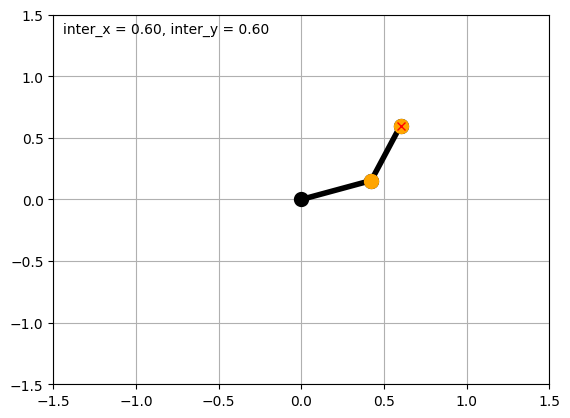

In [8]:
# Function to compute the inverse kinematics using the formulas above
def inverse_kinematics_geometric_approach(px, py, l1, l2):

    # Check if the target can be achieved
    r = np.sqrt(px**2 + py**2)
    if r > (l1 + l2) or r < abs(l1 - l2):
        raise ValueError("Target is out of reach")
    
    # Compute theta2
    cos_theta2 = (px**2 + py**2 - l1**2 - l2**2) / (2 * l1 * l2)
    sin_theta2 = np.sqrt(1 - cos_theta2**2)
    theta2 = np.arctan2(sin_theta2, cos_theta2)

    # Compute theta1
    k1 = l1 + l2 * cos_theta2
    k2 = l2 * sin_theta2
    cos_theta1 = (px * k1 + py * k2) / (px**2 + py**2)
    sin_theta1 = np.sqrt(1 - cos_theta1**2)
    theta1 = np.arctan2(sin_theta1, cos_theta1)

    return theta1, theta2

# End-effector target position
target_x, target_y = 0.6, 0.6

# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
line, = ax.plot([], [], 'o-', lw=4, mew=5, color='black')
joint1, = ax.plot([], [], 'o-', markersize=10, color='orange')  # Joint 1 with red color
joint2, = ax.plot([], [], 'o-', markersize=10, color='orange')  # Joint 2 with green color
target_point, = ax.plot(target_x, target_y, 'rx')  # Plot the target point as a red 'x'
ax.grid()

infoline = ax.text(0.02, 0.95, '', transform=ax.transAxes)

# Animation function
def animate(i):
    # Interpolate positions to create a smooth movement towards the target
    t = i / 99 # Adjust denominator to ensure final frame reaches exactly 1
    inter_x = t * target_x
    inter_y = t * target_y
    
    # Compute inverse kinematics for the interpolated position
    try:
        theta1, theta2 = inverse_kinematics_geometric_approach(inter_x, inter_y, l1, l2)
    except ValueError as e:
        print(f"Frame {i}: {e}")
        return line, target_point
    
    # Calculate the positions of the joints
    x1 = l1 * np.cos(theta1)
    y1 = l1 * np.sin(theta1)
    x2 = x1 + l2 * np.cos(theta1 + theta2)
    y2 = y1 + l2 * np.sin(theta1 + theta2)
    
    # Update the line data
    line.set_data([0, x1, x2], [0, y1, y2])
    joint1.set_data([x1], [y1])
    joint2.set_data([x2], [y2])
    target_point.set_data([target_x], [target_y])  # Ensure the target point is updated correctly
    infoline.set_text(f'inter_x = {inter_x:.2f}, inter_y = {inter_y:.2f}')
    return line, target_point, joint1, joint2

# Create the animation
FuncAnimation(fig, animate, frames=100, init_func=init, blit=True, interval=50)

#### 4.1.2 Algebraic Approach <a class="anchor" id="chapter412"></a>

The distribution of the coordinate frames is shown in the figure below and the __Denavitt–Hartenberg parameters__ are given in the table below.

![](figures/algebralic_approach_inverse_cinematic.png)

*Figure: Specifying the coordinate frame of a robot with two degrees of freedom*

|$\mathbf{i}$    | $\mathbf{\theta}_{\mathbf{i}}$   |  $\mathbf{\alpha}_{\mathbf{i - 1}}$  |  $\mathbf{a}_{\mathbf{i - 1}}$  |   $\mathbf{d}_{\mathbf{i}}$ |
|:-:|:-:|:-:|:-:|:-:|
| 1  |  $\theta_{1}$  |  $0$     |  $0$     |   $0$    |
| 2  |   $\theta_{2}$    |  $0$    |    $l_{1}$   |  $0$    |
| 3  |   $0$ |   $0$ |  $l_{2}$  |    $0$|

*Table: Denavitt-Hartenberg parameters for a robot with two degrees of freedom*

The link transformation matrices are given as follows:

$$_{1}^{0}T = \begin{pmatrix}
C_{1} & {- S}_{1} & 0 & 0 \\
S_{1} & C_{1} & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{pmatrix} $$

$$_{2}^{1}T = \begin{pmatrix}
C_{2} & {- S}_{2} & 0 & l_{1} \\
S_{2} & C_{2} & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{pmatrix} $$

$$_{3}^{2}T = \begin{pmatrix}
1 & 0 & 0 & l_{2} \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{pmatrix} $$

To solve the inverse kinematics of the manipulator with two degrees of freedom, the following equations are used:

$$_{end\ effector}^{base}T\ \ =_{1}^{0}T_{2}^{1}T_{3}^{2}T\ldots_{n}^{n - 1}T$$

$$_{3}^{0}T\ \ =_{1}^{0}T(q_{1})_{2}^{1}T(q_{2})_{3}^{ 2}T(q_{3})$$

Where $q_{i}$ is the link variable (inverse or prismatic link) for links $i\ (i = 1,2,3)$.

$$_{3}^{0}T = \begin{pmatrix}
r_{11} & r_{12} & r_{13} & P_{x} \\
r_{21} & r_{22} & r_{23} & P_{y} \\
r_{31} & r_{32} & r_{33} & P_{z} \\
0 & 0 & 0 & 1
\end{pmatrix} = \ _{1}^{0}T_{2}^{1}T_{3}^{2}T$$

After multiplying each side of the above equation by $_{1}^{0}T^{- 1}$ we get:

$$_{1}^{0}{T^{- 1}\ }_{3}^{0}T = \ _{1}^{0}T^{- 1}\ _{1}^{0}T\ _{2}^{1}T\ _{3}^{2}T$$

Where
$$_{1}^{0}{T^{- 1}\ } = \begin{pmatrix}
_{1}^{0}{R^{T}\ } & -_{1}^{0}R^{T\ \ 0}P_{1} \\
0\ 0\ 0 & 1
\end{pmatrix}$$

In the above equation $_{1}^{0}{R^{T}\ }\ {{and\ \ \ }^{0}P}_{1}\ $ denote the transpose of the rotation and, respectively, the position vector of $_{1}^{0}T$. Since $_{1}^{0}T^{- 1}\ _{1}^{0}T = I$
$(54)$ can be written as follows:

$$_{1}^{0}{T^{- 1}\ }_{3}^{0}T = \ _{2}^{1}T\ _{3}^{2}T$$

After substituting the link transformation matrices into the above equation, the following result is obtained:

$$\begin{pmatrix}
C_{1} & S_{1} & 0 & 0 \\
{- S}_{1} & C_{1} & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{pmatrix}\begin{pmatrix}
r_{11} & r_{12} & r_{13} & P_{x} \\
r_{21} & r_{22} & r_{23} & P_{y} \\
r_{31} & r_{32} & r_{33} & P_{z} \\
0 & 0 & 0 & 1
\end{pmatrix} = \begin{pmatrix}
C_{2} & {- S}_{2} & 0 & l_{1} \\
S_{2} & C_{2} & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{pmatrix}\begin{pmatrix}
1 & 0 & 0 & l_{2} \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{pmatrix}$$

$$\rightarrow \begin{pmatrix}
. & . & . & C_{1}P_{x} + S_{1}P_{y} \\
. & . & . & - S_{1}P_{x} + C_{1}P_{y} \\
. & . & . & P_{z} \\
0 & 0 & 0 & 1
\end{pmatrix} = \ \begin{pmatrix}
. & . & . & l_{2}C_{2} + l_{1} \\
. & . & . & l_{2}S_{2} \\
. & . & . & 0 \\
0 & 0 & 0 & 1
\end{pmatrix}$$

After squaring the matrix elements (1,4) and (2,4) on each side of the above equation, we get:

$$C_{1}^{2}P_{x}^{2} + S_{1}^{2}P_{y}^{2}\  + 2P_{x}P_{y}C_{1}S_{1} = l_{2}^{2}C_{2}^{2} + 2l_{1}l_{2}C_{2} + l_{1}^{2}$$

$$S_{1}^{2}P_{x}^{2} + C_{1}^{2}P_{y}^{2} - 2P_{x}P_{y}C_{1}S_{1} = l_{2}^{2}S_{2}^{2}$$

and after adding the obtained equations above the result is:

$$P_{x}^{2}\left( C_{1}^{2} + S_{1}^{2} \right) + P_{y}^{2}\left( S_{1}^{2} + C_{1}^{2} \right) = l_{2}^{2}\left( C_{2}^{2} + S_{2}^{2} \right) + 2l_{1}l_{2}C_{1} + l_{1}^{2}$$

$$P_{x}^{2} + P_{y}^{2} = l_{2}^{2} + 2l_{1}l_{2}C_{2} + l_{1}^{2}$$

From where $C_{2} = cos\theta_{2}$ and

$$\cos \theta_{2} = \frac{P_{x}^{2} + P_{y}^{2} - l_{1}^{2} - l_{2}^{2}}{2l_{1}l_{2}}$$

Finally, two possible solutions for $\theta_{2}$ using the trigonometric equation

$$cos\theta = a \rightarrow \theta = atan2\left( \pm \sqrt{1 - a^{2}}, a \right)$$

$$\theta_{2} = atan2\ \left( \pm \sqrt{1 - \left( \frac{P_{x}^{2} + P_{y}^{2} - l_{1}^{2} - l_{2}^{2}}{2l_{1}l_{2}} \right)^{2}},\ \frac{P_{x}^{2} + P_{y}^{2} - l_{1}^{2} - l_{2}^{2}}{2l_{1}l_{2}} \right)$$

Once $\theta_{2}$ is found, $\theta_{1}$ can also be found by equate the elements (1,4) on each side of the matrix equation above as follows:

$$C_{1}P_{x} + S_{1}P_{y} = l_{2}C_{2} + l_{1}$$

using the trigonometric equation:

$$asin\theta + bcos\theta = c \rightarrow \theta = atan2(a,b) \pm atan2\left( \sqrt{a^{2} + b^{2} - c^{2}}.\ c \right)$$

Also, two possible solutions for $\theta_{1}$ are obtained:

$$\theta_{1} = atan2\left( P_{y},P_{x} \right) \pm atan2\left( \sqrt{P_{y}^{2} + P_{x}^{2} - {(l_{2}C_{2} + l_{1})}^{2}}.\ l_{2}C_{2} + l_{1} \right)$$

It can also be concluded that the __algebraic approach__ also involves many calculations and transformations related to the necessary matrix operations.



#### 4.1.2.1 Implementation and simulation of the Algebraic Approach <a class="anchor" id="chapter4121"></a>

MovieWriter imagemagick unavailable; using Pillow instead.


Frame 0: Target point is outside the reachable workspace.
Frame 1: Target point is outside the reachable workspace.
Frame 2: Target point is outside the reachable workspace.
Frame 3: Target point is outside the reachable workspace.


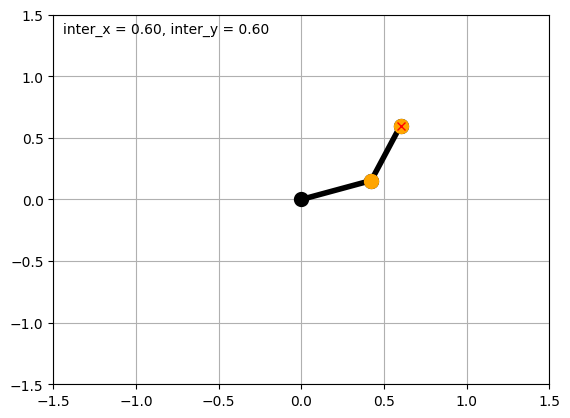

In [9]:
# Function to compute the inverse kinematics using the formulas above
def inverse_kinematics_algebraic_approach(px, py, l1, l2):

    # Check if the target can be achieved
    r = np.sqrt(px**2 + py**2)
    if r > (l1 + l2) or r < abs(l1 - l2):
        raise ValueError("Target point is outside the reachable workspace.")
        
    # Compute theta2
    r_squared = px**2 + py**2
    cos_theta2 = (r_squared - l1**2 - l2**2) / (2 * l1 * l2)
    sin_theta2 = np.sqrt(1 - cos_theta2**2)
    theta2 = np.arctan2(sin_theta2, cos_theta2)

    # Compute theta1
    k1 = l2 * cos_theta2 + l1
    k2 = l2 * sin_theta2
    theta1 = np.arctan2(py, px) - np.arctan2(np.sqrt(r_squared - k1**2), k1)

    return theta1, theta2

# End-effector target position
target_x, target_y = 0.6, 0.6

# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
line, = ax.plot([], [], 'o-', lw=4, mew=5, color='black')
joint1, = ax.plot([], [], 'o-', markersize=10, color='orange')  # Joint 1 with red color
joint2, = ax.plot([], [], 'o-', markersize=10, color='orange')  # Joint 2 with green color
target_point, = ax.plot(target_x, target_y, 'rx')  # Plot the target point as a red 'x'
ax.grid()
infoline = ax.text(0.02, 0.95, '', transform=ax.transAxes)

# Initialization function
def init():
    line.set_data([], [])
    joint1.set_data([], [])
    joint2.set_data([], [])
    return line, joint1, joint2, target_point

# Animation function
def animate(i):
    # Interpolate positions to create a smooth movement towards the target
    t = i / 99 # Adjust denominator to ensure final frame reaches exactly 1
    inter_x = t * target_x
    inter_y = t * target_y
    
    # Compute inverse kinematics for the interpolated position
    try:
        theta1, theta2 = inverse_kinematics_algebraic_approach(inter_x, inter_y, l1, l2)
    except ValueError as e:
        print(f"Frame {i}: {e}")
        return line, target_point
    
    # Calculate the positions of the joints
    x1 = l1 * np.cos(theta1)
    y1 = l1 * np.sin(theta1)
    x2 = x1 + l2 * np.cos(theta1 + theta2)
    y2 = y1 + l2 * np.sin(theta1 + theta2)
    
    # Update the line data
    line.set_data([0, x1, x2], [0, y1, y2])
    joint1.set_data([x1], [y1])
    joint2.set_data([x2], [y2])
    target_point.set_data([target_x], [target_y])  # Ensure the target point is updated correctly
    infoline.set_text(f'inter_x = {inter_x:.2f}, inter_y = {inter_y:.2f}')
    return line, joint1, joint2, target_point

# Create the animation
FuncAnimation(fig, animate, frames=100, init_func=init, blit=True, interval=50)


#### 4.1.3 Newton's Method <a class="anchor" id="chapter413"></a>

In numerical analysis, Newton's method, also known as the Newton–Raphson method, named after Isaac Newton and Joseph Raphson, is a root-finding algorithm which produces successively better approximations to the roots (or zeroes) of a real-valued function.

Newton's Method for Inverse Kinematics is an iterative numerical technique used to find the joint parameters that produce a desired end-effector position and orientation in robotic systems. It involves linearizing the relationship between the joint parameters and the end-effector position using the Jacobian matrix and iteratively updating the joint parameters to minimize the error.

Here the needed step to implement the Newton's method for a 2 DOF (degree of freedom): 

1. **Initialize** the joint parameters $\theta = [\theta_1, \theta_2]^T$.

2. **Compute** the forward kinematics to get the current end-effector position $\mathbf{x}(\theta)$:
    $$
   \mathbf{x}(\theta) = \begin{bmatrix} 
   x(\theta_1, \theta_2) \\ 
   y(\theta_1, \theta_2) 
   \end{bmatrix}
    $$
   For a 2 DOF planar manipulator, this might look like:
    $$ 
   \mathbf{x}(\theta) = \begin{bmatrix} 
   l_1 \cos(\theta_1) + l_2 \cos(\theta_1 + \theta_2) \\ 
   l_1 \sin(\theta_1) + l_2 \sin(\theta_1 + \theta_2) 
   \end{bmatrix}
    $$
   where $(l_1)$ and $(l_2)$ are the lengths of the manipulator's links.

4. **Compute** the error $\mathbf{e}$ between the desired position $\mathbf{x}_{d}$ and the current position $\mathbf{x}(\theta)$:
   
   $$\mathbf{e} = \mathbf{x}_{d} - \mathbf{x}(\theta)$$
   

5. **Compute** the Jacobian matrix $(\mathbf{J})$ at the current joint parameters:
   $$
   \mathbf{J} = \begin{bmatrix} 
   \frac{\partial x}{\partial \theta_1} & \frac{\partial x}{\partial \theta_2} \\ 
   \frac{\partial y}{\partial \theta_1} & \frac{\partial y}{\partial \theta_2} 
   \end{bmatrix}
   $$
   For our 2 DOF planar manipulator, the partial derivatives are:
   $$
   \mathbf{J} = \begin{bmatrix} 
   -l_1 \sin(\theta_1) - l_2 \sin(\theta_1 + \theta_2) & -l_2 \sin(\theta_1 + \theta_2) \\ 
   l_1 \cos(\theta_1) + l_2 \cos(\theta_1 + \theta_2) & l_2 \cos(\theta_1 + \theta_2) 
   \end{bmatrix}
   $$

6. **Update** the joint parameters using the Newton-Raphson update rule:
   $$
   \theta_{\text{new}} = \theta_{\text{old}} + \mathbf{J}^{\dagger} \mathbf{e}
   $$
   where $(\mathbf{J}^{\dagger})$ is the pseudoinverse of the Jacobian matrix, typically computed as:
   $$
   \mathbf{J}^{\dagger} = \mathbf{J}^T (\mathbf{J} \mathbf{J}^T)^{-1}
   $$

7. **Repeat** steps 2-5 until the error $(\mathbf{e})$ is sufficiently small or a maximum number of iterations is reached.




#### 4.1.3.1 Implementation and simulation of Newton's Approach <a class="anchor" id="chapter4131"></a>

MovieWriter imagemagick unavailable; using Pillow instead.


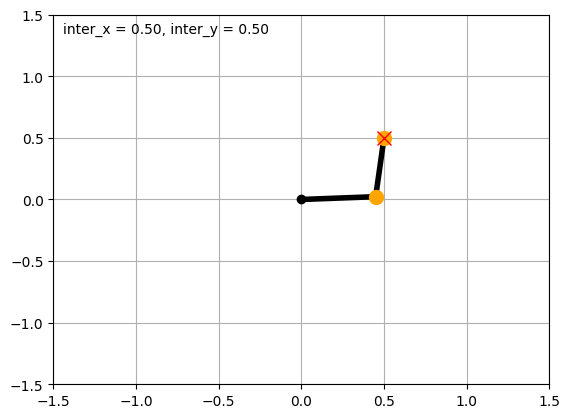

In [10]:
# End-effector target position
target_x, target_y = 0.5, 0.5

# Initial guess for theta1 and theta2
theta1_init, theta2_init = 0.0, 0.0

# Function to compute the forward kinematics
def forward_kinematics(theta1, theta2, l1, l2):
    x = l1 * np.cos(theta1) + l2 * np.cos(theta1 + theta2)
    y = l1 * np.sin(theta1) + l2 * np.sin(theta1 + theta2)
    return x, y

# Function to compute the Jacobian matrix
def jacobian(theta1, theta2, l1, l2):
    J = np.array([
        [-l1 * np.sin(theta1) - l2 * np.sin(theta1 + theta2), -l2 * np.sin(theta1 + theta2)],
        [l1 * np.cos(theta1) + l2 * np.cos(theta1 + theta2), l2 * np.cos(theta1 + theta2)]
    ])
     # Add a small value to the diagonal for damping to solve the error message "LinAlgError: Singular matrix"
    J += np.eye(len(J)) * 1e-6
    return J



def is_reachable(target_x, target_y, l1, l2):
  max_reach = l1 + l2
  distance = np.sqrt(target_x**2 + target_y**2)
  return distance <= max_reach

# Function to compute the error vector
def error_vector(theta1, theta2, l1, l2, target_x, target_y):
    x = l1 * np.cos(theta1) + l2 * np.cos(theta1 + theta2)
    y = l1 * np.sin(theta1) + l2 * np.sin(theta1 + theta2)
    e = np.array([target_x - x, target_y - y])
    return e
    
# Newton's method to solve inverse kinematics
def newtons_method(target_x, target_y, theta1_init, theta2_init, l1, l2, tol=1e-6, max_iter=1000):
    theta1, theta2 = theta1_init, theta2_init
    
    for _ in range(max_iter):
        x, y = forward_kinematics(theta1, theta2, l1, l2)
        e = error_vector(theta1, theta2, l1, l2, target_x, target_y)
        if np.linalg.norm(e) < tol:
            break
        J = jacobian(theta1, theta2, l1, l2)
       
        #delta_theta = np.linalg.solve(J, e)
        #theta1 += delta_theta[0]
        #theta2 += delta_theta[1]

        # Limit maximum change in joint angles
        max_delta_theta = 0.1  # Adjust this value based on desired speed
        delta_theta = np.linalg.solve(J, e)
        delta_theta = np.clip(delta_theta, -max_delta_theta, max_delta_theta)
    
        theta1 += delta_theta[0]
        theta2 += delta_theta[1]
    return theta1, theta2


# Calculate inverse kinematics for the target position using Newton's method
theta1, theta2 = newtons_method(target_x, target_y, theta1_init, theta2_init, l1, l2)

# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
links, = ax.plot([], [], 'o-', lw=4, color='black')  # Link 1 with blue color
joint1, = ax.plot([], [], 'o-', markersize=10, color="orange")  # Joint 1 with red color
joint2, = ax.plot([], [], 'o-', markersize=10, color="orange")  # Joint 2 with green color
ax.grid()
target_point, = ax.plot(target_x, target_y, 'rx', markersize=10)  # Target point as a red 'x'
infoline = ax.text(0.02, 0.95, '', transform=ax.transAxes)

# Initialization function
def init():
    links.set_data([], [])
    joint1.set_data([], [])
    joint2.set_data([], [])
    return links, joint1, joint2, target_point

# Animation function
def animate(i):
    # Interpolate positions to create a smooth movement towards the target
    t = i / 99
    inter_x = t * target_x
    inter_y = t * target_y
    
    # Compute inverse kinematics for the interpolated position using Newton's method
    try:
        theta1, theta2 = newtons_method(inter_x, inter_y, theta1_init, theta2_init, l1, l2)
        theta1_new, theta2_new = newtons_method(inter_x, inter_y, theta1_init, theta2_init, l1, l2)
        theta1 = theta1_init + t * (theta1_new - theta1_init)
        theta2 = theta2_init + t * (theta2_new - theta2_init)
       
    except ValueError as e:
        print(f"Frame {i}: {e}")
        return link1, link2, joint1, joint2, target_point
    
    # Calculate the positions of the joints
    x1 = l1 * np.cos(theta1)
    y1 = l1 * np.sin(theta1)
    x2 = x1 + l2 * np.cos(theta1 + theta2)
    y2 = y1 + l2 * np.sin(theta1 + theta2)
    
    # Update the link and joint data
    links.set_data([0, x1, x2], [0, y1, y2])
    joint1.set_data([x1], [y1])
    joint2.set_data([x2], [y2])
    target_point.set_data([target_x], [target_y])  # Ensure the target point is updated correctly
    infoline.set_text(f'inter_x = {inter_x:.2f}, inter_y = {inter_y:.2f}')
    return links, joint1, joint2, target_point

# Create the animation
FuncAnimation(fig, animate, frames=100, init_func=init, blit=True, interval=50)


## 5. Literature <a class="anchor" id="chapter5"></a>
[1] [https://open.ocolearnok.org/physicalscience/chapter/basics-of-kinematics/](https://open.ocolearnok.org/physicalscience/chapter/basics-of-kinematics/) <br>
[2] [](https://cdn.intechopen.com/pdfs/379/InTech-Robot_kinematics_forward_and_inverse_kinematics.pdf) <br>
[3] [](https://en.wikipedia.org/wiki/Newton%27s_method) <br>
[4] [](https://modernrobotics.northwestern.edu/nu-gm-book-resource/6-2-numerical-inverse-kinematics-part-1-of-2/) <br>
[5] [](https://bjpcjp.github.io/pdfs/robotics/MR_ch06_inverse_kinematics.pdf) <br>
[6] [](https://automaticaddison.com/find-homogeneous-transformation-matrices-for-a-robotic-arm/) <br>
[7] [](http://studywolf.wordpress.com/2013/09/20/python-visualization-with-matplotlib/) <br>
[8] [](https://en.wikipedia.org/wiki/Robot_kinematics) <br>
[9] [](https://en.wikipedia.org/wiki/Inverse_kinematics) <br>
[10] [](https://github.com/devrt/inverse-kinematics-primer/blob/master/notebooks/inverse-kinematics-primer-en.ipynb) <br>
[11] [](https://irisdynamics.com/articles/forward-and-inverse-kinematic) <br>
[12] [](https://en.wikipedia.org/wiki/Denavit%E2%80%93Hartenberg_parameters) <br> 
[13] [](https://mecharithm.com/learning/lesson/homogenous-transformation-matrices-configurations-in-robotics-12) <br>